## Neural Part Of Speech Tagging

We're now going to solve the same problem of POS tagging with neural networks.
<img src=https://i.stack.imgur.com/6pdIT.png width=320>

From deep learning perspective, this is a task of predicting a sequence of outputs aligned to a sequence of inputs. There are several problems that match this formulation:
* Part Of Speech Tagging -  an auxuliary task for many NLP problems
* Named Entity Recognition - for chat bots and web crawlers
* Protein structure prediction - for bioinformatics

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import nltk
import sys
import numpy as np

nltk.download('brown')
nltk.download('universal_tagset')
data = nltk.corpus.brown.tagged_sents(tagset='universal')
all_tags = ['#EOS#','#UNK#','ADV', 'NOUN', 'ADP', 'PRON', 'DET', '.', 'PRT', 'VERB', 'X', 'NUM', 'CONJ', 'ADJ']

data = np.array([ [(word.lower(),tag) for word,tag in sentence] for sentence in data ])

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
<ipython-input-2-bc9847c14597>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([ [(word.lower(),tag) for word,tag in sentence] for sentence in data ])


In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data,test_size=0.25,random_state=42)

In [4]:
from IPython.display import HTML, display
def draw(sentence):
    words,tags = zip(*sentence)
    display(HTML('<table><tr>{tags}</tr>{words}<tr></table>'.format(
                words = '<td>{}</td>'.format('</td><td>'.join(words)),
                tags = '<td>{}</td>'.format('</td><td>'.join(tags)))))


draw(data[11])
draw(data[10])
draw(data[7])

NOUN,ADP,NOUN,NOUN,NOUN,NOUN,VERB,ADV,VERB,ADP,DET,ADJ,NOUN,.,implementation,of,georgia's,automobile,title,law,was,also,recommended,by,the,outgoing,jury,.


PRON,VERB,ADP,DET,NOUN,.,VERB,NOUN,PRT,VERB,.,DET,NOUN,.,it,urged,that,the,city,``,take,steps,to,remedy,'',this,problem,.


NOUN,VERB,merger,proposed


### Building vocabularies

Just like before, we have to build a mapping from tokens to integer ids. This time around, our model operates on a word level, processing one word per RNN step. This means we'll have to deal with far larger vocabulary.

Luckily for us, we only receive those words as input i.e. we don't have to predict them. This means we can have a large vocabulary for free by using word embeddings.

In [5]:
from collections import Counter
word_counts = Counter()
for sentence in data:
    words,tags = zip(*sentence)
    word_counts.update(words)

all_words = ['#EOS#','#UNK#'] + list(list(zip(*word_counts.most_common(10000)))[0])

#let's measure what fraction of data words are in the dictionary
print("Coverage = %.5f" % (float(sum(word_counts[w] for w in all_words)) / sum(word_counts.values())))

Coverage = 0.92876


In [6]:
from collections import defaultdict
word_to_id = defaultdict(lambda:1, { word: i for i, word in enumerate(all_words) })
tag_to_id = { tag: i for i, tag in enumerate(all_tags)}

convert words and tags into fixed-size matrix

In [7]:
def to_matrix(lines, token_to_id, max_len=None, pad=0, dtype='int32', time_major=False):
    """Converts a list of names into rnn-digestable matrix with paddings added after the end"""

    max_len = max_len or max(map(len,lines))
    matrix = np.empty([len(lines), max_len],dtype)
    matrix.fill(pad)

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.__getitem__,lines[i]))[:max_len]
        matrix[i,:len(line_ix)] = line_ix

    return matrix.T if time_major else matrix

In [8]:
batch_words, batch_tags = zip(*[zip(*sentence) for sentence in data[-3:]])

print("Word ids:")
print(to_matrix(batch_words, word_to_id))
print("Tag ids:")
print(to_matrix(batch_tags, tag_to_id))

Word ids:
[[   2 3057    5    2 2238 1334 4238 2454    3    6   19   26 1070   69
     8 2088    6    3    1    3  266   65  342    2    1    3    2  315
     1    9   87  216 3322   69 1558    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [  45   12    8  511 8419    6   60 3246   39    2    1    1    3    2
   845    1    3    1    3   10 9910    2    1 3470    9   43    1    1
     3    6    2 1046  385   73 4562    3    9    2    1    1 3250    3
    12   10    2  861 5240   12    8 8936  121    1    4]
 [  33   64   26   12  445    7 7346    9    8 3337    3    1 2811    3
     2  463  572    2    1    1 1649   12    1    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
Tag ids:
[[ 6  3  4  6  3  3  9  9  7 12  4  5  9  4  6  3 12  7  9  7  9  8  4  6
   3  7  6 13  3  4  6  3  9  4  3  7  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0

### Build model

Unlike our previous lab, this time we'll focus on a high-level keras interface to recurrent neural networks. It is as simple as you can get with RNN, allbeit somewhat constraining for complex tasks like seq2seq.

By default, all keras RNNs apply to a whole sequence of inputs and produce a sequence of hidden states `(return_sequences=True` or just the last hidden state `(return_sequences=False)`. All the recurrence is happening under the hood.

At the top of our model we need to apply a Dense layer to each time-step independently. As of now, by default keras.layers.Dense would apply once to all time-steps concatenated. We use __keras.layers.TimeDistributed__ to modify Dense layer so that it would apply across both batch and time axes.

In [9]:
import keras
import keras.layers as L

model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.SimpleRNN(64,return_sequences=True))

#add top layer that predicts tag probabilities
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          500100    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          7360      
                                                                 
 time_distributed (TimeDist  (None, None, 14)          910       
 ributed)                                                        
                                                                 
Total params: 508370 (1.94 MB)
Trainable params: 508370 (1.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


__Training:__ in this case we don't want to prepare the whole training dataset in advance. The main cause is that the length of every batch depends on the maximum sentence length within the batch. This leaves us two options: use custom training code as in previous seminar or use generators.

Keras models have a __`model.fit_generator`__ method that accepts a python generator yielding one batch at a time. But first we need to implement such generator:

In [11]:
import tensorflow
from tensorflow.keras.utils import to_categorical

BATCH_SIZE=32
def generate_batches(sentences,batch_size=BATCH_SIZE,max_len=None,pad=0):
    assert isinstance(sentences,np.ndarray),"Make sure sentences is q numpy array"

    while True:
        indices = np.random.permutation(np.arange(len(sentences)))
        for start in range(0,len(indices)-1,batch_size):
            batch_indices = indices[start:start+batch_size]
            batch_words,batch_tags = [],[]
            for sent in sentences[batch_indices]:
                words,tags = zip(*sent)
                batch_words.append(words)
                batch_tags.append(tags)

            batch_words = to_matrix(batch_words,word_to_id,max_len,pad)
            batch_tags = to_matrix(batch_tags,tag_to_id,max_len,pad)

            batch_tags_1hot = to_categorical(batch_tags,len(all_tags)).reshape(batch_tags.shape+(-1,))
            yield batch_words,batch_tags_1hot


__Callbacks:__ Another thing we need is to measure model performance. The tricky part is not to count accuracy after sentence ends (on padding) and making sure we count all the validation data exactly once.

While it isn't impossible to persuade Keras to do all of that, we may as well write our own callback that does that.
Keras callbacks allow you to write a custom code to be ran once every epoch or every minibatch. We'll define one via LambdaCallback

In [12]:
def compute_test_accuracy(model):
    test_words,test_tags = zip(*[zip(*sentence) for sentence in test_data])
    test_words,test_tags = to_matrix(test_words,word_to_id),to_matrix(test_tags,tag_to_id)

    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model.predict(test_words,verbose=1)
    predicted_tags = predicted_tag_probabilities.argmax(axis=-1)

    #compute accurary excluding padding
    numerator = np.sum(np.logical_and((predicted_tags == test_tags),(test_words != 0)))
    denominator = np.sum(test_words != 0)
    return float(numerator)/denominator


class EvaluateAccuracy(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        sys.stdout.flush()
        print("\nMeasuring validation accuracy...")
        acc = compute_test_accuracy(self.model)
        print("\nValidation accuracy: %.5f\n"%acc)
        sys.stdout.flush()

In [13]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

model.compile('adam','categorical_crossentropy', 'categorical_accuracy')

history_simple_rnn = model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=7,)

Epoch 1/7


<ipython-input-13-3de8c8798f97>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_simple_rnn = model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,


1344/1343 [==============================] - ETA: 0s - loss: 0.2706 - categorical_accuracy: 0.9293
Measuring validation accuracy...
448/448 [==============================] - 7s 14ms/step

Validation accuracy: 0.93970

1343/1343 [==============================] - 128s 87ms/step - loss: 0.2706 - categorical_accuracy: 0.9293
Epoch 2/7
1343/1343 [============================>.] - ETA: 0s - loss: 0.0596 - categorical_accuracy: 0.9797
Measuring validation accuracy...
448/448 [==============================] - 8s 17ms/step

Validation accuracy: 0.94428

1343/1343 [==============================] - 93s 69ms/step - loss: 0.0596 - categorical_accuracy: 0.9797
Epoch 3/7
1343/1343 [============================>.] - ETA: 0s - loss: 0.0523 - categorical_accuracy: 0.9819
Measuring validation accuracy...
448/448 [==============================] - 6s 14ms/step

Validation accuracy: 0.94582

1343/1343 [==============================] - 87s 65ms/step - loss: 0.0523 - categorical_accuracy: 0.9819
Epoch 4

Measure final accuracy on the whole test set.

In [14]:
acc = compute_test_accuracy(model)
print("Final accuracy: %.5f"%acc)

assert acc>0.94, "Keras has gone on a rampage again, please contact course staff."

448/448 [==============================] - 6s 13ms/step
Final accuracy: 0.94300


In [15]:
history_simple_rnn.history['categorical_accuracy']

[0.9292523860931396,
 0.9797329902648926,
 0.981917142868042,
 0.9836170673370361,
 0.9850707650184631,
 0.9863767623901367,
 0.9878627061843872]

In [16]:
history_simple_rnn.history['loss']

[0.2706223726272583,
 0.05961362272500992,
 0.05230584368109703,
 0.04729577526450157,
 0.04320787638425827,
 0.03980327397584915,
 0.0358576700091362]

### Going bidirectional

Since we're analyzing a full sequence, it's legal for us to look into future data.

A simple way to achieve that is to go both directions at once, making a __bidirectional RNN__.

In Keras you can achieve that both manually (using two LSTMs and Concatenate) and by using __`keras.layers.Bidirectional`__.

This one works just as `TimeDistributed` we saw before: you wrap it around a recurrent layer (SimpleRNN now and LSTM/GRU later) and it actually creates two layers under the hood.

Your first task is to use such a layer our POS-tagger.

In [17]:
from tensorflow.keras.layers import Bidirectional, SimpleRNN, Embedding, Dense
# Assuming you have a vocabulary size and maximum sequence length defined
# vocab_size = 10000
# max_seq_length = 50
# embedding_dim = 50
# hidden_units = 64
# num_classes = 14эUser
# было
model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Bidirectional(L.SimpleRNN(units=64, return_sequences=True)))
model.add(L.SimpleRNN(64,return_sequences=True))

stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)
# # Define the model
# model = keras.models.Sequential()
# model.add(Embedding(input_dim=len(all_words), output_dim=50, input_length=max_seq_length))
# model.add(Bidirectional(SimpleRNN(units=64, return_sequences=True)))
# model.add(Dense(units=len(all_tags), activation='softmax'))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          500100    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         14720     
 al)                                                             
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 64)          12352     
                                                                 
 time_distributed_1 (TimeDi  (None, None, 14)          910       
 stributed)                                                      
                                                                 
Total params: 528082 (2.01 MB)
Trainable params: 528082 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.compile('adam','categorical_crossentropy', 'categorical_accuracy')

history_bidirectional_rnn = model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=7,)

Epoch 1/7


<ipython-input-19-d942769c4366>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_bidirectional_rnn = model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,


1344/1343 [==============================] - ETA: 0s - loss: 0.1702 - categorical_accuracy: 0.9512
Measuring validation accuracy...
448/448 [==============================] - 18s 39ms/step

Validation accuracy: 0.95657

1343/1343 [==============================] - 281s 207ms/step - loss: 0.1702 - categorical_accuracy: 0.9512
Epoch 2/7
1344/1343 [==============================] - ETA: 0s - loss: 0.0408 - categorical_accuracy: 0.9871
Measuring validation accuracy...
448/448 [==============================] - 18s 40ms/step

Validation accuracy: 0.96122

1343/1343 [==============================] - 234s 174ms/step - loss: 0.0408 - categorical_accuracy: 0.9871
Epoch 3/7
1344/1343 [==============================] - ETA: 0s - loss: 0.0324 - categorical_accuracy: 0.9896
Measuring validation accuracy...
448/448 [==============================] - 19s 43ms/step

Validation accuracy: 0.96285

1343/1343 [==============================] - 233s 174ms/step - loss: 0.0324 - categorical_accuracy: 0.9896

In [21]:
acc = compute_test_accuracy(model)
print("\nFinal accuracy: %.5f"%acc)

assert acc>0.95, "Bidirectional RNNs are better than this!"
print("Well done!")

448/448 [==============================] - 20s 44ms/step

Final accuracy: 0.95851
Well done!


In [23]:
history_bidirectional_rnn.history['categorical_accuracy']

[0.9512391090393066,
 0.9870539307594299,
 0.9895918369293213,
 0.9916633367538452,
 0.9934714436531067,
 0.9950549006462097,
 0.9961273670196533]

In [24]:
history_bidirectional_rnn.history['loss']

[0.17015938460826874,
 0.04084467142820358,
 0.03235436603426933,
 0.02617514133453369,
 0.02070772834122181,
 0.016042960807681084,
 0.01271740160882473]

Create **at least one experiment** from the list bellow, you can choose the most interesting and promising options to improve the performance of Bidirectional LSTM:

* __Go beyond SimpleRNN__: there's `keras.layers.LSTM` and `keras.layers.GRU`
  * If you want to use a custom recurrent Cell, read [this](https://keras.io/layers/recurrent/#rnn)
  * You can also use 1D Convolutions (`keras.layers.Conv1D`). They are often as good as recurrent layers but with less overfitting.
* __Stack more layers__: if there is a common motif to this course it's about stacking layers
  * You can just add recurrent and 1dconv layers on top of one another and keras will understand it
  * Just remember that bigger networks may need more epochs to train
* __Regularization__: you can apply dropouts as usual but also in an RNN-specific way
  * `keras.layers.Dropout` works inbetween RNN layers
  * Recurrent layers also have `recurrent_dropout` parameter
* __Gradient clipping__: If your training isn't as stable as you'd like, set `clipnorm` in your optimizer.
  * Which is to say, it's a good idea to watch over your loss curve at each minibatch. Try tensorboard callback or something similar.

In [25]:
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding, Dense

model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Bidirectional(L.LSTM(units=64, return_sequences=True)))
model.add(L.LSTM(64,return_sequences=True))

stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          500100    
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         58880     
 onal)                                                           
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 time_distributed_2 (TimeDi  (None, None, 14)          910       
 stributed)                                                      
                                                                 
Total params: 609298 (2.32 MB)
Trainable params: 609298 (2.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
model.compile('adam','categorical_crossentropy', 'categorical_accuracy')

history_lstm_rnn = model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=7,)

Epoch 1/7


<ipython-input-27-653b1a002f33>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_rnn = model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,


1341/1343 [============================>.] - ETA: 0s - loss: 0.3267 - categorical_accuracy: 0.9003
Measuring validation accuracy...
448/448 [==============================] - 4s 8ms/step

Validation accuracy: 0.95059

1343/1343 [==============================] - 55s 36ms/step - loss: 0.3261 - categorical_accuracy: 0.9004
Epoch 2/7
1342/1343 [============================>.] - ETA: 0s - loss: 0.0509 - categorical_accuracy: 0.9844
Measuring validation accuracy...
448/448 [==============================] - 4s 8ms/step

Validation accuracy: 0.95961

1343/1343 [==============================] - 25s 18ms/step - loss: 0.0509 - categorical_accuracy: 0.9844
Epoch 3/7
1343/1343 [============================>.] - ETA: 0s - loss: 0.0404 - categorical_accuracy: 0.9872
Measuring validation accuracy...
448/448 [==============================] - 4s 9ms/step

Validation accuracy: 0.96209

1343/1343 [==============================] - 23s 17ms/step - loss: 0.0404 - categorical_accuracy: 0.9872
Epoch 4/7
1

In [28]:
acc = compute_test_accuracy(model)
print("\nFinal accuracy: %.5f"%acc)

448/448 [==============================] - 4s 9ms/step

Final accuracy: 0.96431


In [29]:
history_lstm_rnn.history['categorical_accuracy']

[0.9004387855529785,
 0.9844443798065186,
 0.9872261881828308,
 0.9887247085571289,
 0.9899719953536987,
 0.9910458922386169,
 0.9920371770858765]

In [30]:
history_lstm_rnn.history['loss']

[0.3261205554008484,
 0.05087604001164436,
 0.04035494476556778,
 0.035474732518196106,
 0.03157756105065346,
 0.028117503970861435,
 0.025003761053085327]

In [109]:
from tensorflow.keras.layers import Bidirectional, GRU, Embedding, Dense

model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Bidirectional(L.GRU(units=64, return_sequences=True)))
model.add(L.GRU(64,return_sequences=True))

stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

In [110]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, None, 50)          500100    
                                                                 
 bidirectional_11 (Bidirect  (None, None, 128)         44544     
 ional)                                                          
                                                                 
 gru_13 (GRU)                (None, None, 64)          37248     
                                                                 
 time_distributed_19 (TimeD  (None, None, 14)          910       
 istributed)                                                     
                                                                 
Total params: 582802 (2.22 MB)
Trainable params: 582802 (2.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [111]:
model.compile('adam','categorical_crossentropy', 'categorical_accuracy')

history_gru_rnn = model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=7,)

Epoch 1/7


<ipython-input-111-60cb8a219208>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_gru_rnn = model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,


1340/1343 [============================>.] - ETA: 0s - loss: 0.1837 - categorical_accuracy: 0.9476
Measuring validation accuracy...
448/448 [==============================] - 5s 8ms/step

Validation accuracy: 0.95699

1343/1343 [==============================] - 47s 31ms/step - loss: 0.1833 - categorical_accuracy: 0.9477
Epoch 2/7
1341/1343 [============================>.] - ETA: 0s - loss: 0.0424 - categorical_accuracy: 0.9865
Measuring validation accuracy...
448/448 [==============================] - 4s 9ms/step

Validation accuracy: 0.96278

1343/1343 [==============================] - 24s 18ms/step - loss: 0.0424 - categorical_accuracy: 0.9865
Epoch 3/7
1341/1343 [============================>.] - ETA: 0s - loss: 0.0354 - categorical_accuracy: 0.9887
Measuring validation accuracy...
448/448 [==============================] - 3s 7ms/step

Validation accuracy: 0.96516

1343/1343 [==============================] - 24s 18ms/step - loss: 0.0354 - categorical_accuracy: 0.9887
Epoch 4/7
1

In [112]:
acc = compute_test_accuracy(model)
print("\nFinal accuracy: %.5f"%acc)

448/448 [==============================] - 3s 8ms/step

Final accuracy: 0.96584


In [113]:
history_gru_rnn.history['categorical_accuracy']

[0.9477091431617737,
 0.9865134358406067,
 0.9887171983718872,
 0.9901491403579712,
 0.991070568561554,
 0.9920034408569336,
 0.9928154349327087]

In [114]:
history_gru_rnn.history['loss']

[0.18328650295734406,
 0.04241006076335907,
 0.03542233631014824,
 0.030937615782022476,
 0.027811145409941673,
 0.024948129430413246,
 0.022452393546700478]

In [117]:
from tensorflow.keras.layers import Bidirectional, GRU, Embedding, Dense, MaxPooling1D

model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(L.Bidirectional(L.GRU(units=64, return_sequences=True)))
model.add(L.GRU(64,return_sequences=True))

stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)


In [118]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, None, 50)          500100    
                                                                 
 conv1d_18 (Conv1D)          (None, None, 64)          9664      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, None, 64)          0         
 ng1D)                                                           
                                                                 
 bidirectional_12 (Bidirect  (None, None, 128)         49920     
 ional)                                                          
                                                                 
 gru_15 (GRU)                (None, None, 64)          37248     
                                                                 
 time_distributed_20 (TimeD  (None, None, 14)        

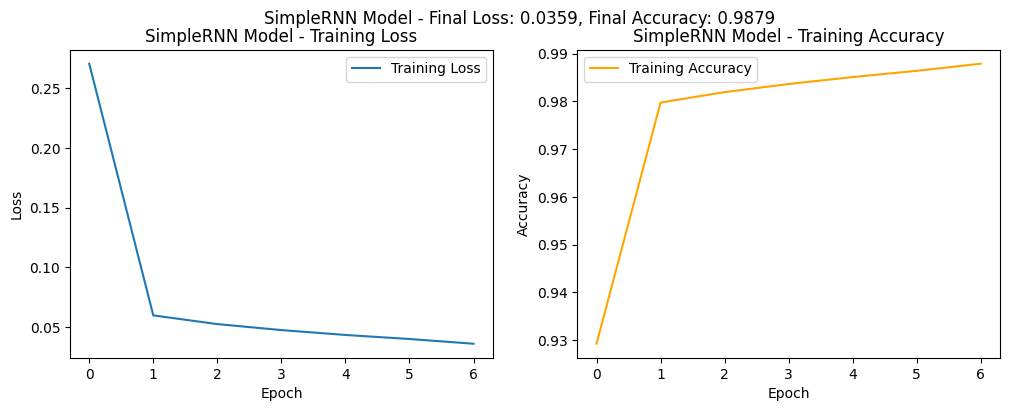

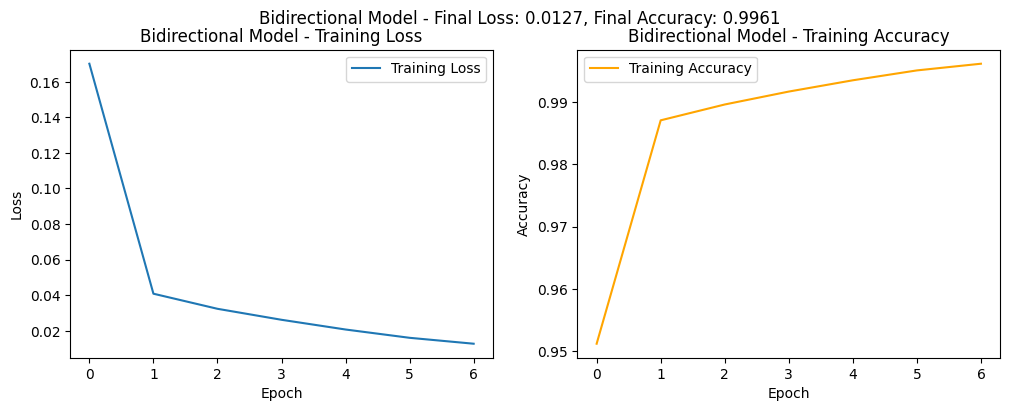

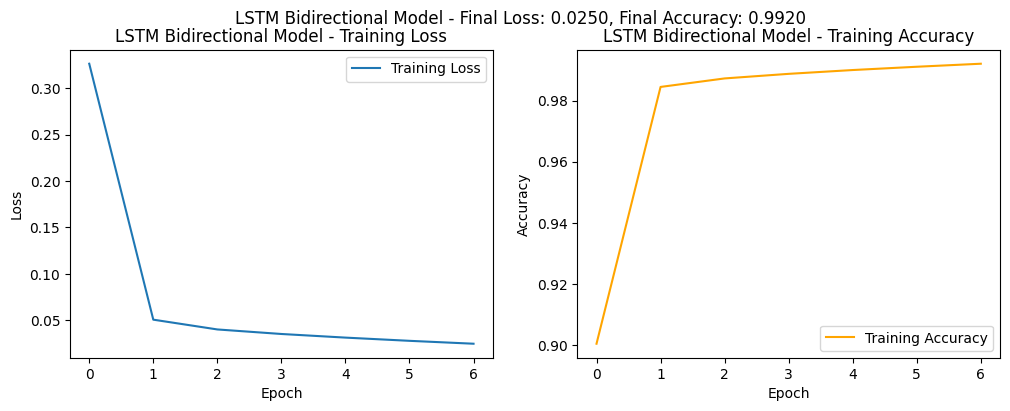

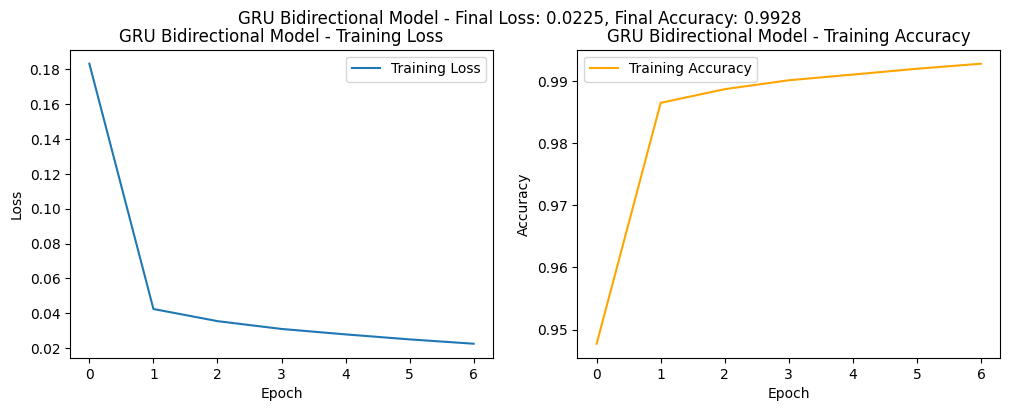

In [120]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, title):
    # Получение значений loss и accuracy из объекта history
    loss = history['loss']
    accuracy = history['categorical_accuracy']

    # Создание подзаголовка для графика
    subtitle = f'{title} - Final Loss: {loss[-1]:.4f}, Final Accuracy: {accuracy[-1]:.4f}'

    # Создание графика для loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.title(f'{title} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Создание графика для accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy', color='orange')
    plt.title(f'{title} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Добавление подзаголовка
    plt.suptitle(subtitle)

    # Отображение графиков
    plt.show()

# Вызов функции для каждой модели
plot_learning_curves(history_simple_rnn.history, 'SimpleRNN Model')
plot_learning_curves(history_bidirectional_rnn.history, 'Bidirectional Model')
plot_learning_curves(history_lstm_rnn.history, 'LSTM Bidirectional Model')
plot_learning_curves(history_gru_rnn.history, 'GRU Bidirectional Model')


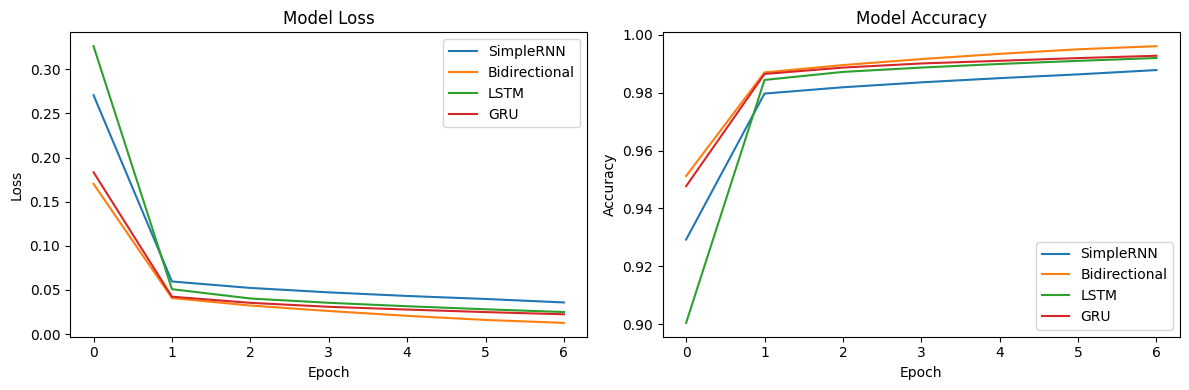

In [121]:
import matplotlib.pyplot as plt

def plot_curves(history, model_names):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for i, h in enumerate(history):
        plt.plot(h['loss'], label=f'{model_names[i]}')

    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i, h in enumerate(history):
        plt.plot(h['categorical_accuracy'], label=f'{model_names[i]}')

    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

history = [history_simple_rnn.history, history_bidirectional_rnn.history, history_lstm_rnn.history, history_gru_rnn.history]
model_names = ['SimpleRNN', 'Bidirectional', 'LSTM', 'GRU']

plot_curves(history, model_names)

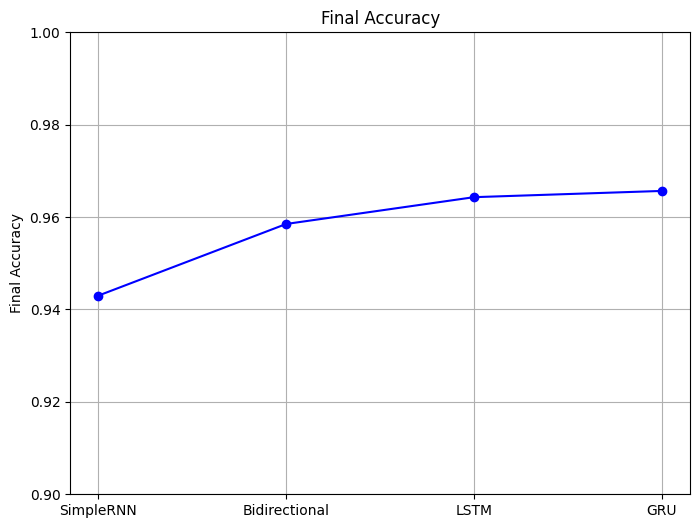

In [116]:
import matplotlib.pyplot as plt

model_names = ['SimpleRNN', 'Bidirectional', 'LSTM', 'GRU']
final_accuracies = [0.94300, 0.95851, 0.96431, 0.96566]

plt.figure(figsize=(8, 6))
plt.plot(model_names, final_accuracies, marker='o', linestyle='-', color='blue')
plt.title('Final Accuracy')
plt.ylabel('Final Accuracy')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()


'Bidirectional' модель показывает лучший accuracy на тренировочных данных, а на валидационной выборки LSTM и GRU все-таки показывает лучшую точность. Это может говорить о том, что двунаправленная модель немного заучивает ответы (но не сильно). А LSTM и GRU чуть лучше находит закрономерности.  
Быстрее всго с обучением справляется GRU. Данная модель двунаправленная, как и все, кроме SimpleRNN. Мое предпочтение точно уходит GRU
